In [116]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import minimize
from typing import List
import sys

%matplotlib inline

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [117]:
def maximize(x):
    return np.maximum(x, 0)

class ConditionalOpt:
    
    def __init__(self, x0, A, b, plenty, method, **kwargs):
        self.A = A
        self.b = b
        self.x0 = x0
        self.method = method
        self.plenty = plenty
        self.kwargs = kwargs
        self.penalty = self.penalty(plenty=plenty)
        self.Xk = x0.copy()
        self.H_Xk = [x0.copy()]
    
    def f(self, x):
        return 0.5 * x.T @ self.A.dot(x) + self.b.T.dot(x)     
        
    def penalty(self, plenty):    
        if plenty == "sphere":
            return self.sphere
        elif plenty == "box":
            return self.box
        else:
            return self.round_pen
        
          
    def sphere(self, x, t, center, radius):
        fun = self.f(x)
        cost = maximize(np.sum((x - center)**2) - radius**2)
        return fun + t * cost**2
    
    def box(self, x, t, l, r):
        fun = self.f(x)
        cost = np.sum(maximize(l - x)) + np.sum(maximize(x - r))
        return fun + t * cost**2

    def round_pen(self, x, t, center, radius):
        fun = self.f(x)
        cost = maximize(np.sum((x - center)**2) - radius**2) + maximize(radius**2 - np.sum((x - center)**2))
        penalty = fun + t * cost**2
        return penalty
    
    def extrem(self, n_iter):
        for t in range(1, n_iter + 1):
            args_dict = {**{"t": t}, **self.kwargs}
            args_tuple = tuple(args_dict.values())
            opt_res = minimize(self.penalty, args=args_tuple, x0=self.Xk, method=self.method)
            self.Xk = opt_res.x
            self.H_Xk.append(opt_res.x)
        return self
    
    def plot(self, d=4.0):
        u = np.linspace(-d, d, 300)
        x, y = np.meshgrid(u,u)
        grid = np.dstack([x, y])
        z = np.apply_along_axis(self.f, 2, grid)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.contour(x, y, z, levels=np.logspace(0, 5, 50), norm=LogNorm(), cmap=plt.cm.jet)
        if self.plenty == "sphere":
            plenty = plt.Circle(self.kwargs['center'], self.kwargs['radius'], 
                                color='purple', alpha=0.5)
        elif self.plenty == "round":
            plenty = plt.Circle(self.kwargs['center'], self.kwargs['radius'], 
                    color='purple', fill=False)
        else:
            plenty = plt.Rectangle(self.kwargs['l'], *self.kwargs['r'],
                                   color='purple', alpha=0.5)
        ax.add_artist(plenty)
        ax.plot(*self.Xk, 'r*', markersize=18, label="Xk")
        ax.plot(*self.x0, 'r.', markersize=18, label="x0")
        plt.legend()
        plt.title(f"plenty={self.plenty}, method={self.method}")
        
        return fig

Задаем параметры из условия

In [118]:
A = np.array([[1., 0.4],
              [0.4, 2.]])
b = np.array([1., 1.])
x0_a = np.array([-3., -2.])
x0_b = np.array([1., 2.])

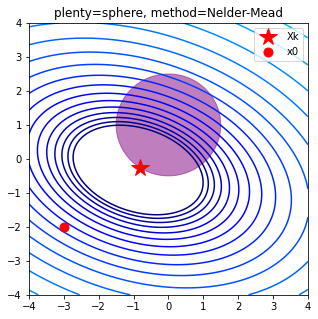

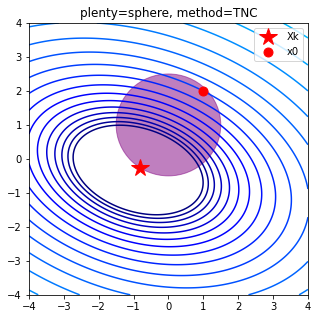

In [119]:
sphere_a = ConditionalOpt(
    x0=x0_a, A=A, b=b, 
    plenty="sphere", center=np.array([0., 1.]),
    radius=1.5, method='Nelder-Mead'
).extrem(n_iter=100)

sphere_b = ConditionalOpt(
    x0=x0_b, A=A, b=b, 
    plenty="sphere", center=np.array([0., 1.]),
    radius=1.5, method='TNC'
).extrem(n_iter=100)

sphere_a.plot();
sphere_b.plot();

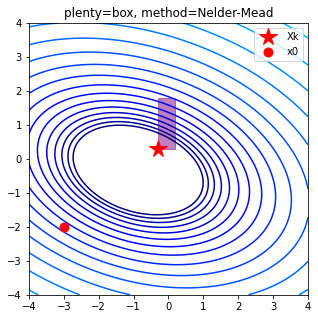

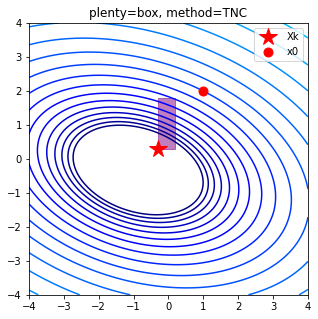

In [120]:
box_a = ConditionalOpt(
    x0=x0_a, A=A, b=b, 
    plenty="box", l=np.array([-0.3, 0.3]),
    r=np.array([0.5, 1.5]), method='Nelder-Mead'
).extrem(n_iter=100)

box_b = ConditionalOpt(
    x0=x0_b, A=A, b=b, 
    plenty="box", l=np.array([-0.3, 0.3]),
    r=np.array([0.5, 1.5]), method='TNC'
).extrem(n_iter=100)

box_a.plot();
box_b.plot();

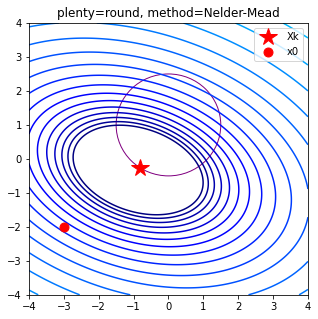

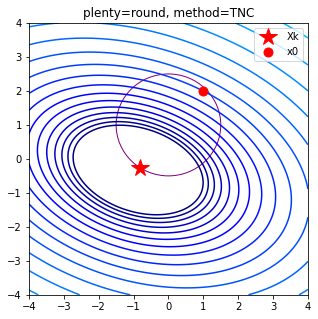

In [121]:
round_a = ConditionalOpt(
    x0=x0_a, A=A, b=b, 
    plenty="round", center=np.array([0., 1.]),
    radius=1.5, method='Nelder-Mead',
).extrem(n_iter=100)

round_b = ConditionalOpt(
    x0=x0_b, A=A, b=b, 
    plenty="round", center=np.array([0., 1.]),
    radius=1.5, method='TNC'
).extrem(n_iter=100)

round_a.plot();
round_b.plot();